In [2]:
%load_ext autoreload
%autoreload 2
from slow_eq import JapanSlowSlipCatalog, EarthquakeCatalog
from decluster import time_torchETAS_decluster as decluster
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
import seaborn as sns
import cartopy.crs as ccrs
import pandas as pd

def sqrt(x):
    return np.sqrt(np.abs(x))

mpl.rcParams.update({'font.size': 8})
mpl.rcParams.update({'figure.dpi': 200})
plt.style.use("tableau-colorblind10")


In [3]:
slowslip_events = JapanSlowSlipCatalog()
slowslip_events.catalog.head()

,index,year,month,day,hour,min,sec,lat,lon,dep,...,dip,rake,length,width,slip,duration,catalog,ref,udate,time
234,0,1994,12,1,NaN,NaN,NaN,35.466,138.72701,7.4,...,33.0,59.0,36.0,40.0,0.011,86400.0,Nishimura2021c-SSE,Nishimura (2021),2021-08-30,1994-12-01
443,0,1994,12,29,NaN,NaN,NaN,35.815,140.35600,34.4,...,17.0,134.0,41.0,58.0,0.020,1728000.0,Nishimura2021b-SSE,Nishimura (2021),2021-08-30,1994-12-29
145,0,1995,1,16,NaN,NaN,NaN,35.350,142.09100,9.8,...,14.0,112.0,39.0,41.0,0.359,1900800.0,Nishimura2021a-SSE,Nishimura (2021),2021-08-30,1995-01-16
146,1,1995,4,12,NaN,NaN,NaN,36.155,142.20200,14.1,...,15.0,110.0,41.0,39.0,0.068,345600.0,Nishimura2021a-SSE,Nishimura (2021),2021-08-30,1995-04-12
235,1,1995,4,27,NaN,NaN,NaN,35.164,138.13300,27.5,...,19.0,128.0,33.0,58.0,0.023,3456000.0,Nishimura2021c-SSE,Nishimura (2021),2021-08-30,1995-04-27


In [4]:
earthquakes = EarthquakeCatalog(
    "_temp_local_catalog.csv",
    kwargs={"minimum_magnitude":4},
    use_other_catalog=True,
    other_catalog=slowslip_events,
)

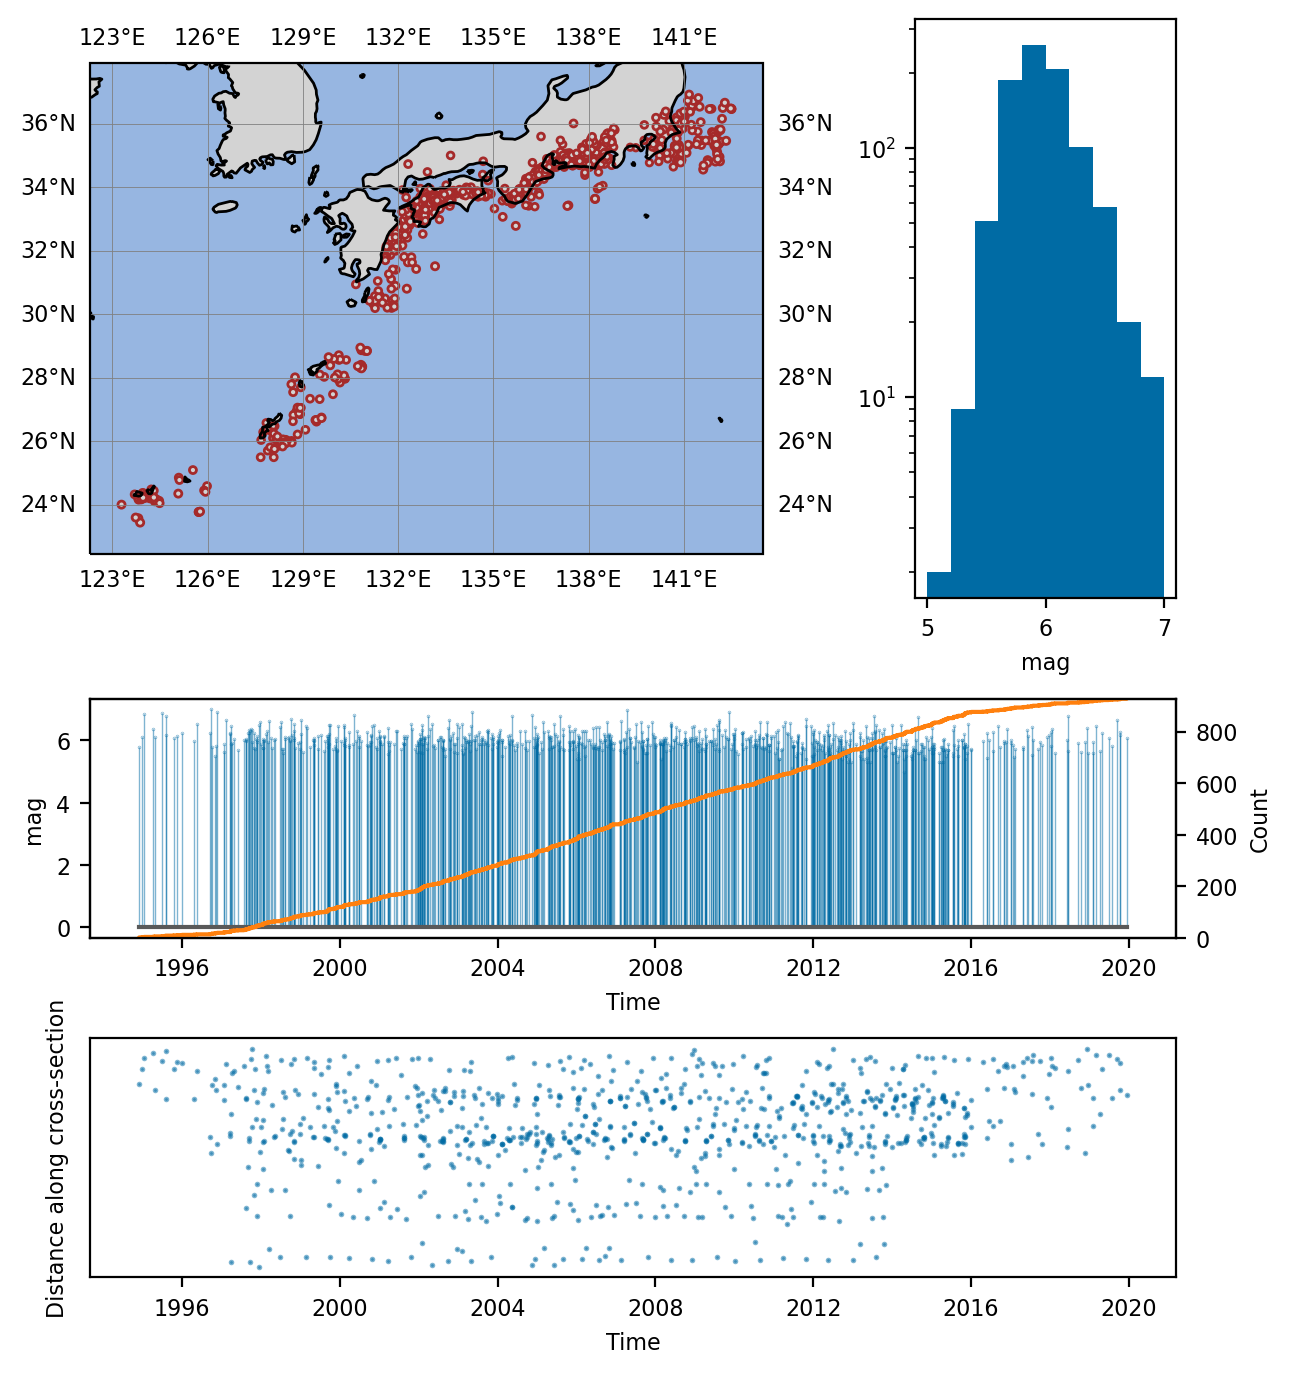

In [5]:
slowslip_events.plot_summary();

<AxesSubplot: xlabel='Time', ylabel='Distance along cross-section'>

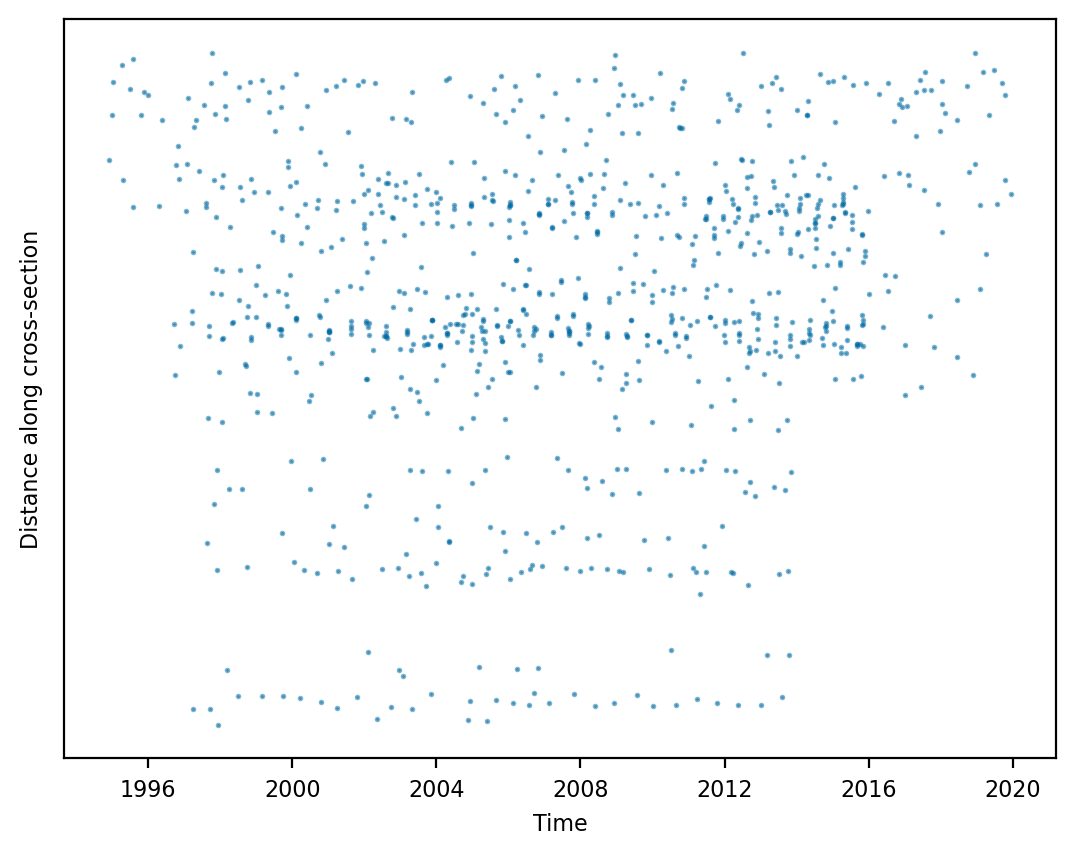

In [6]:
slowslip_events.plot_space_time_series()

## TODO: 

It looks like there may be some duplicate events here in the catalog.

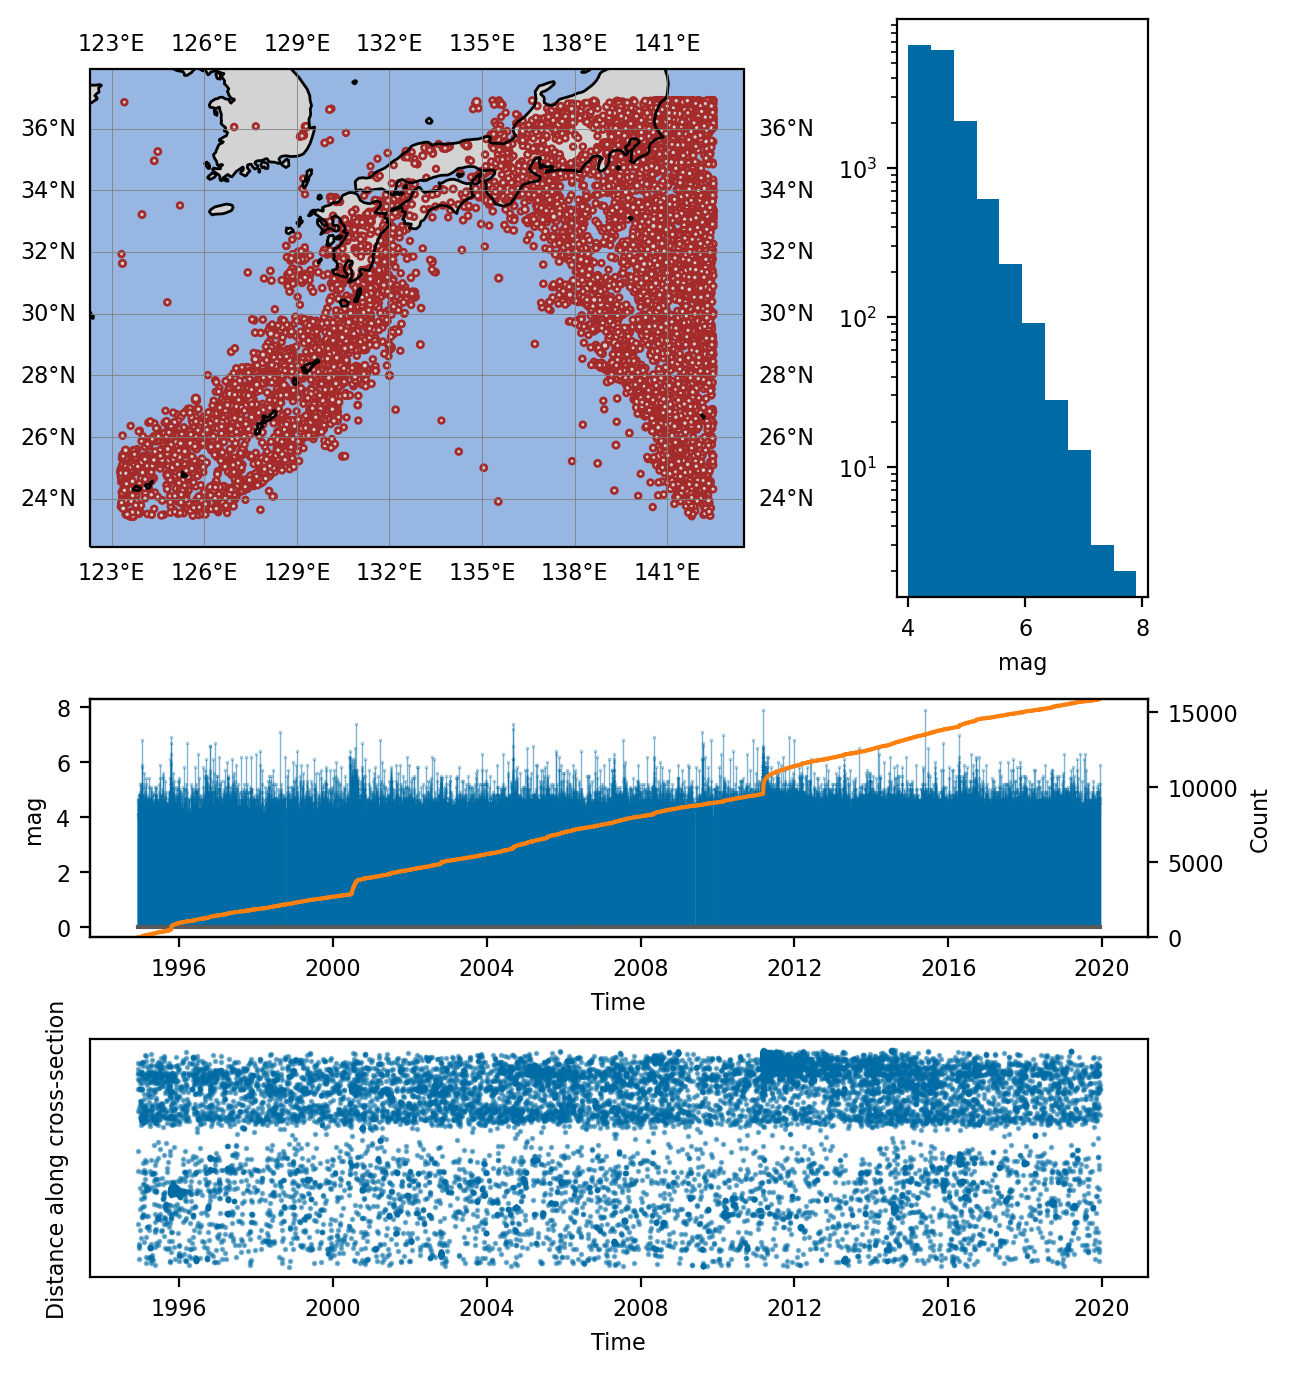

In [7]:
earthquakes.plot_summary();

I select a subperiod that I consider to be more homogeneously sampled. I also do not consider, for the purposes of the following analysis, anything after the Tohoku Earthquake.

/Users/kdascher/miniforge3/envs/torch_earthquake_stat/lib/python3.10/site-packages/eq-0.0.1-py3.10.egg/eq/data/sequence.py:153: UserWarning: Found 2 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kdascher/miniforge3/envs/torch_earthquake_stat/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


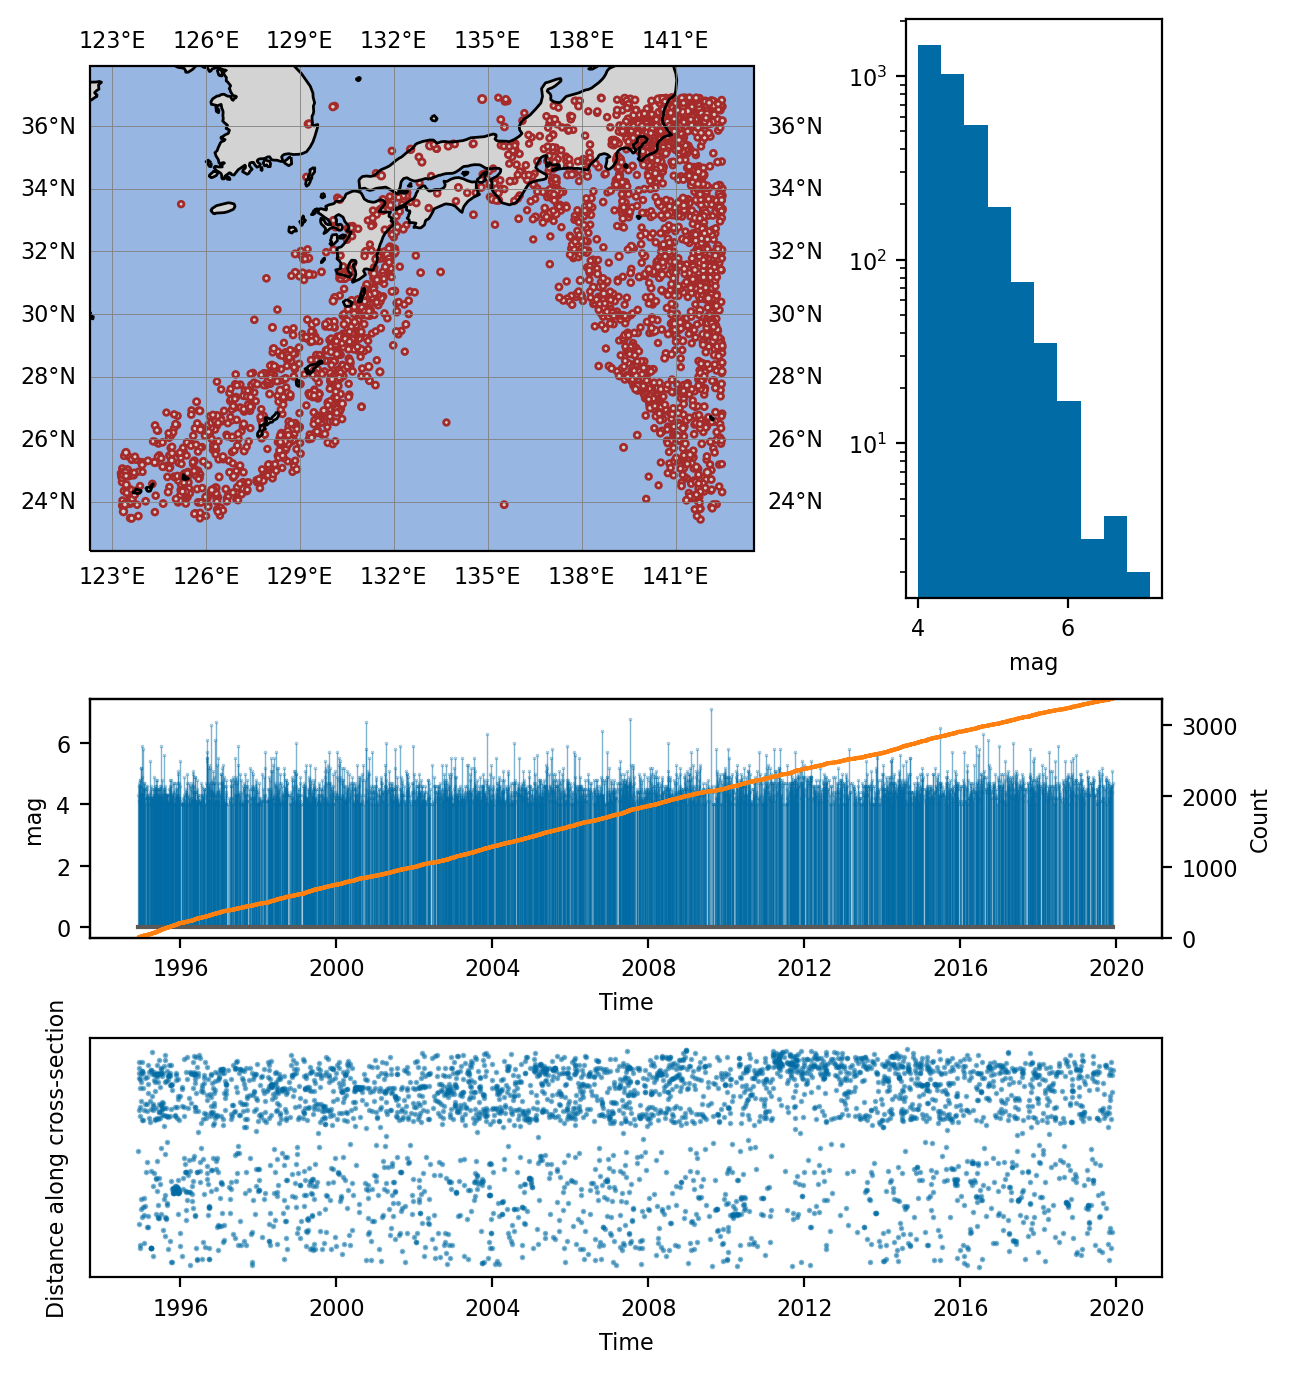

In [8]:
apply_declustering = True
if apply_declustering is True: 
    earthuqakes = decluster(earthquakes) 
    earthuqakes.plot_summary() 

In [9]:
start_time, end_time = [pd.Timestamp(2000,1,1),pd.Timestamp(2011,3,1)]

local_earthquakes = earthquakes.intersection(slowslip_events,buffer_radius_km=25.0)
local_earthquakes = local_earthquakes.get_time_slice(start_time,end_time)
slowslip_events = slowslip_events.get_time_slice(start_time,end_time)

<GeoAxesSubplot: xlabel='Longitude', ylabel='Latitude'>

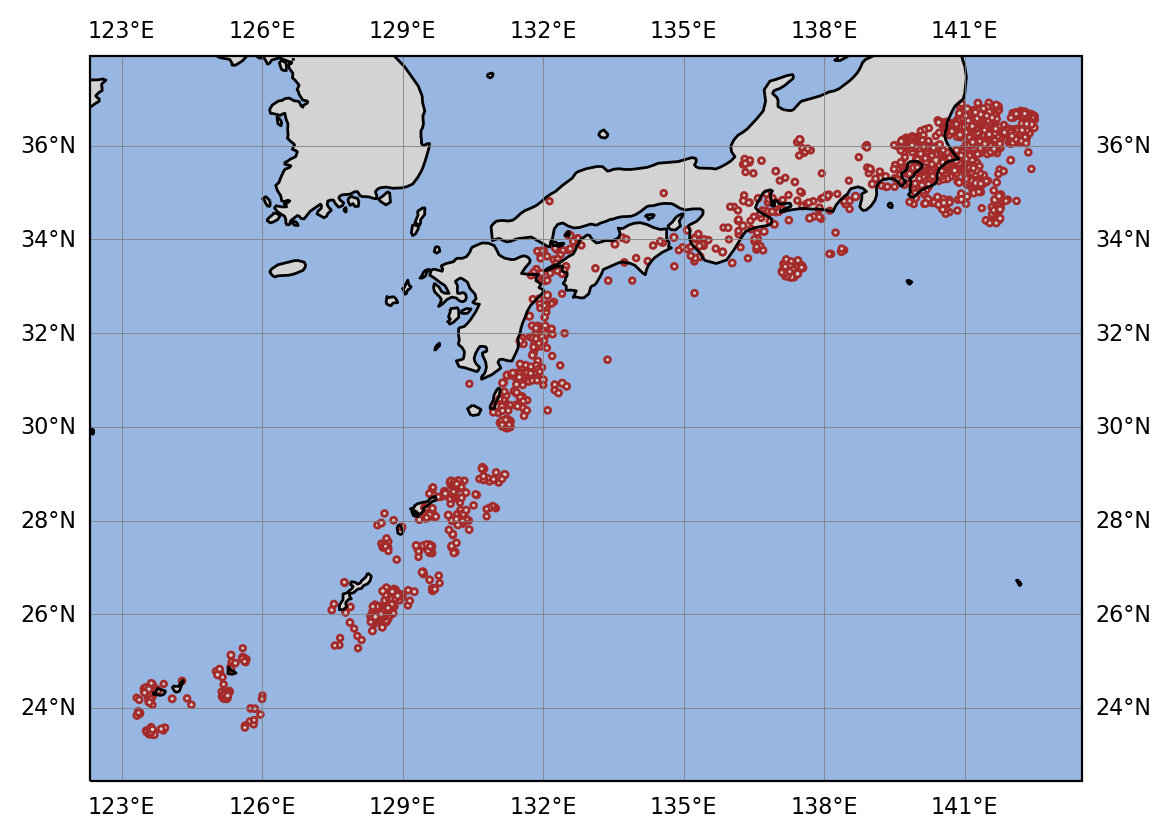

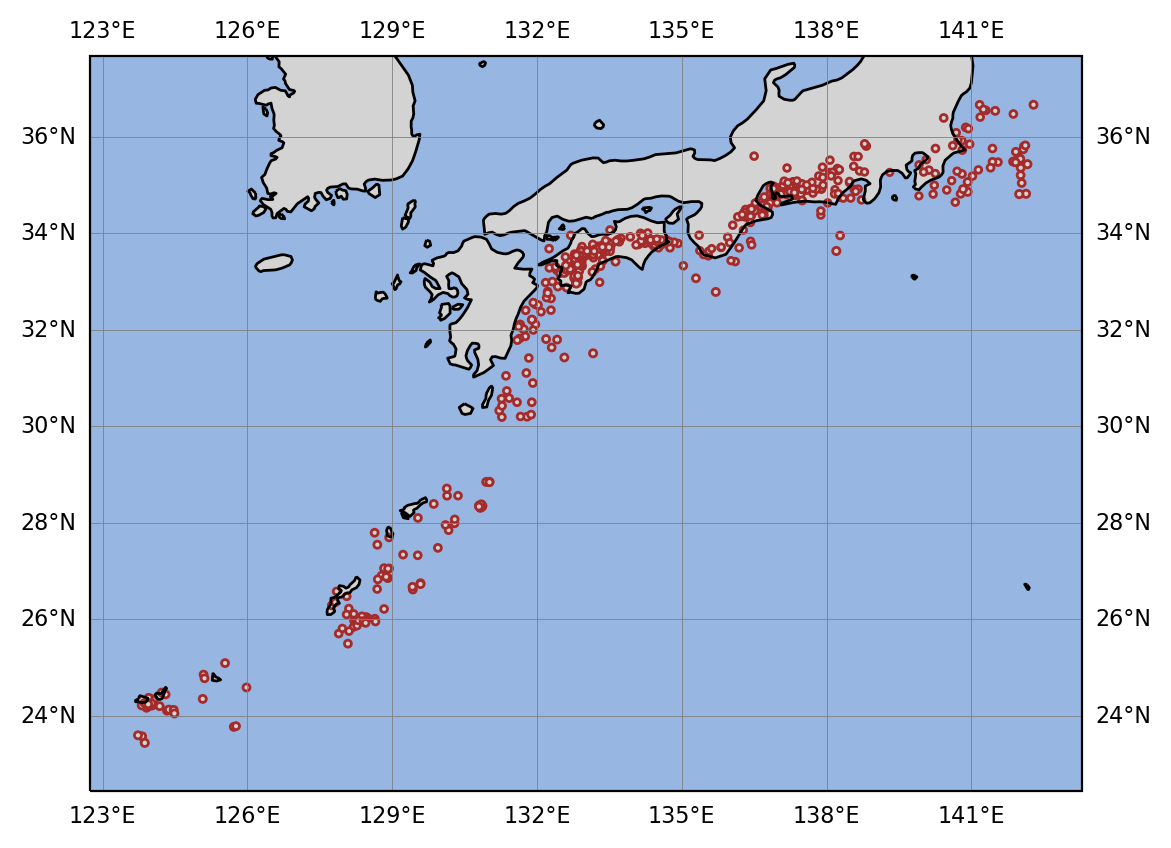

In [10]:
local_earthquakes.plot_map()
slowslip_events.plot_map()

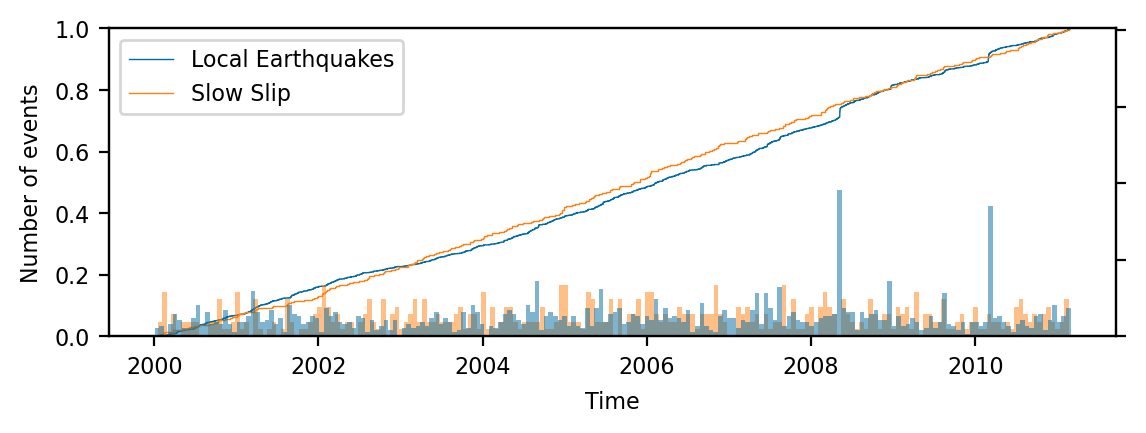

In [11]:
fig, ax = plt.subplots(figsize=(6.5,2))

kwargs = {'lw':0.5}

sns.ecdfplot(
    local_earthquakes.catalog["time"], 
    label="Local Earthquakes",
    **kwargs,
    ax=ax,
)

sns.ecdfplot(
    slowslip_events.catalog["time"],
    label="Slow Slip",
    **kwargs,
    ax=ax,
)

axb = ax.twinx()
axb.hist(slowslip_events.catalog.time, bins=200,color='C1', alpha=0.5,density=True)
axb.hist(local_earthquakes.catalog.time, bins=200,color='C0', alpha=0.5,density=True)
ylim = axb.get_ylim()
axb.set_ylim(ylim[0], ylim[1]*2)
axb.set_yticklabels([])

ax.set_xlabel("Time")
ax.set_ylabel("Number of events")
ax.legend();

### Do slow slip events cause earthquakes?

The most crude thing I can envisage doing is to calculate:


$$ R = t_2/(t_1+t_2) $$ 

where t_2 is the time between a slow slip event and the next local earthquake, and t_1 is the time between the previous local earthquake and the slow slip event. 

Next we can obtain $n$ using: 

$$R = \frac{1}{n^2}[(n+1)\ln(n+1)-n]$$

where

$$ n = \frac{r_2 - r_1}{r_1} $$

representing the change in base rate after a slow slip event.


/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_34972/3052293142.py:4: RuntimeWarning: invalid value encountered in log
  f = R - 1/n**2 * ((n+1)*np.log(n+1)-n)


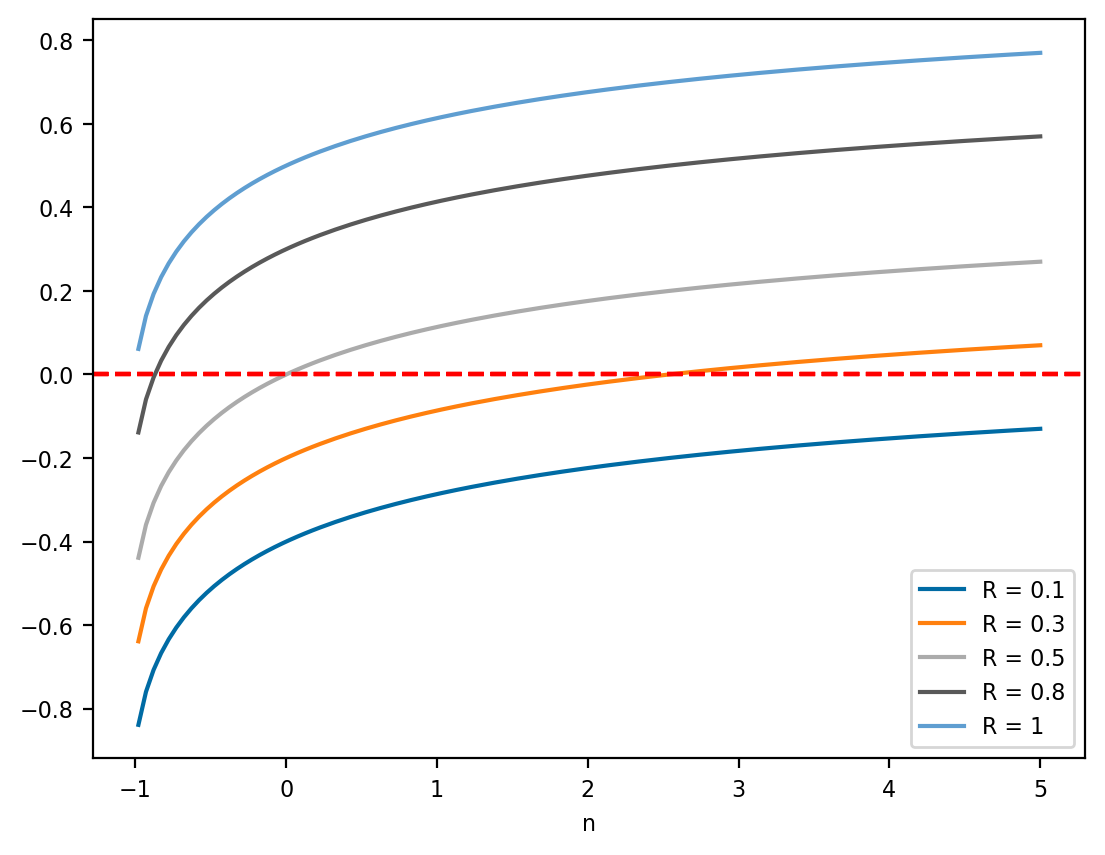

In [12]:
n = np.linspace(-5, 5, 200)
fig, ax = plt.subplots() 
for R in [0.1, 0.3, 0.5, 0.8, 1]:
    f = R - 1/n**2 * ((n+1)*np.log(n+1)-n)
    ax.plot(n, f, label=f"R = {R}")
    ax.axhline(0, color="r", linestyle="--")
ax.set_xlabel("n")
ax.legend();

In [13]:
def get_R(T1, T2, sort=False):
    """ Gets the R value of each time in the sorted array T2 given the array of sorted times T.
    
    Get the time differences per Brodsky & Van Der Elst, 2014
    ----------------------------------------------------------
    ----------T1[ind-1]------t1-----T2-------t2----T1[ind]----
    ----------------------------------------------------------
    note:
    T1[ind-1] < T2 <= T1[ind]

    input arguments:
    T1: array of times
    T2: array of times
    sort: if True, T1 and T2 will be sorted before calculating R

    output:
    R: array of R values of length T2 trimmed to all T2 within the range of T1

    """

    if sort:
        T1 = np.sort(T1)
        T2 = np.sort(T2)

    ind = np.searchsorted(T1,T2)

    # Get rid of times that are too early or too late
    index_in_range = (ind > 0) & (ind < len(T1))
    
    T2 = T2[index_in_range]
    ind = ind[index_in_range]

    t1 = (T2 - T1[ind-1]) / np.timedelta64(1, 's')
    t2 = (T1[ind] - T2) / np.timedelta64(1, 's')

    R = t2/(t1+t2)

    return R

def get_R_from_catalogs(catalog1,catalog2):
    """ Gets the R value of each event in catalog2 given catalog1. Assumes both catalogs are sorted by time. """
    
    T1 = catalog1.time.to_numpy()
    T2 = catalog2.time.to_numpy()

    return get_R(T1, T2)

def get_n(R, eps=1e-15):
    """ Gets the n value for a given R value using newton root finding. """

    root = scipy.optimize.root_scalar(
        lambda n: R - 1/n**2 * ((n+1)*np.log(n+1)-n),
        method="brentq",
        bracket=[-1+eps, 1/eps],
        x0=0, # this initial guess ensures that proper convergence is achieved (as far as I can tell)
    ).root

    return root

def get_n_from_catalogs(catalog1, catalog2):
    """ Gets the n value for a given querry catalog within another catalog. Assumes both catalogs are sorted by time. """
    R = get_R_from_catalogs(catalog1, catalog2)
    return np.array([get_n(r) for r in R])
    
    

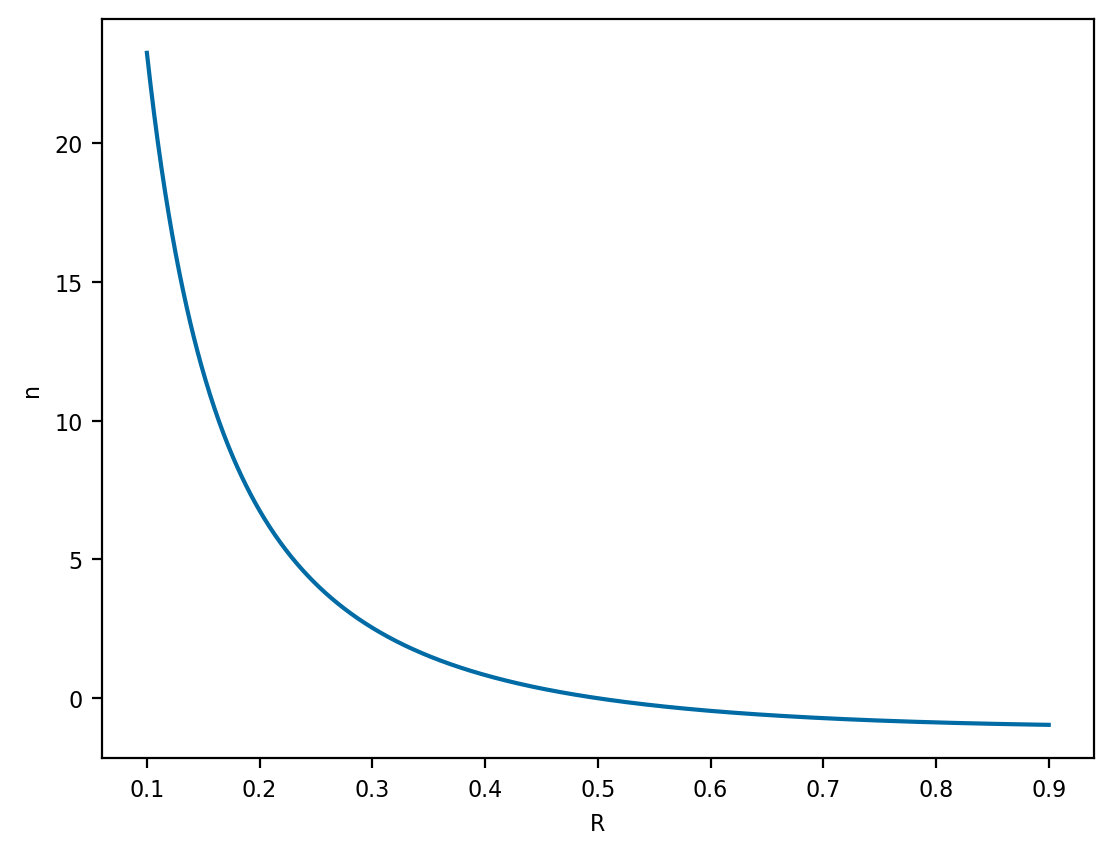

In [14]:
R = np.linspace(0.1, 0.9, 1000)
n = np.array(list(map(get_n, R)))

fig, ax = plt.subplots()
ax.plot(R, n)
ax.set_xlabel("R")
ax.set_ylabel("n");

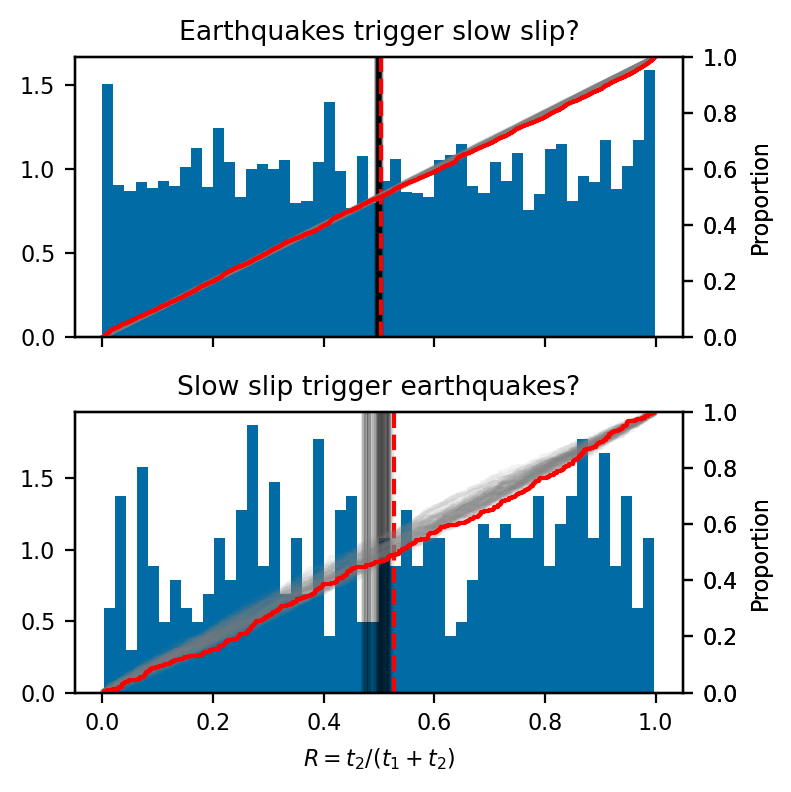

In [15]:
def visualize_statistic(catalog1, catalog2, stat_fun = None, ax=None, range=None):
    if ax is None:
        fig, ax = plt.subplots()
        axb = ax.twinx()
    stat = stat_fun(catalog1, catalog2)
    ax.hist(stat,range=range, bins=50, density=True)
    axb = ax.twinx()
    sns.ecdfplot(stat.T,color="r",ax=axb,legend=False)
    ax.axvline(stat.mean(), color="r", linestyle="--")

def visualize_null_statistic(Nobs, Nsamp=50, ax=None,transform_to_n=False):

    if ax is None:
        fig, ax = plt.subplots()

    rand_stat = np.random.rand(Nsamp, Nobs)
    rand_stat.sort()

    if transform_to_n:
        rand_stat = np.vectorize(get_n)(rand_stat)
        rand_stat.sort()
        
    axb = ax.twinx()
    sns.ecdfplot(rand_stat.T,palette=("grey",), alpha=0.1,ax=axb,legend=False)
    [ax.axvline(v, color="k", alpha=0.1) for v in rand_stat.mean(axis=1)]

fig, ax = plt.subplots(2,1,sharex=True, dpi=200, figsize=(4,4))

visualize_null_statistic(len(earthquakes.catalog), ax=ax[0])
visualize_null_statistic(len(slowslip_events.catalog), ax=ax[1])

visualize_statistic(slowslip_events.catalog, earthquakes.catalog, get_R_from_catalogs, ax=ax[0])
ax[0].set_title('Earthquakes trigger slow slip?')
visualize_statistic(earthquakes.catalog, slowslip_events.catalog, get_R_from_catalogs, ax=ax[1])
ax[1].set_title('Slow slip trigger earthquakes?')


ax[1].set_xlabel(r"$ R = t_2/(t_1+t_2) $")
plt.tight_layout()


**Figures**: These figures respectively show the R and n values for earthquakes clock advance to due to slow slip (top) and slow slip event clock advance due to earthquakes (bottom). Smaller values of R and higher values of n implie clock advance. In blue are the raw histragms of the corresponding values. The red curves are the corresponding CDFs. The vertical dashed lines are the mean values of the data. 

The grey lines are generated from random data. 

My interpretation of this data is that there little to no statistically significant results. There is a potentially a hint of a clock advance in the bottom set (earthquakes tend to be clock advanced by slow slip events).

I also conclude that n is a far stranger measurements that it first would appear.

Note that the high abundance of very small and very large R values in the top panel might be related to swarm activity.

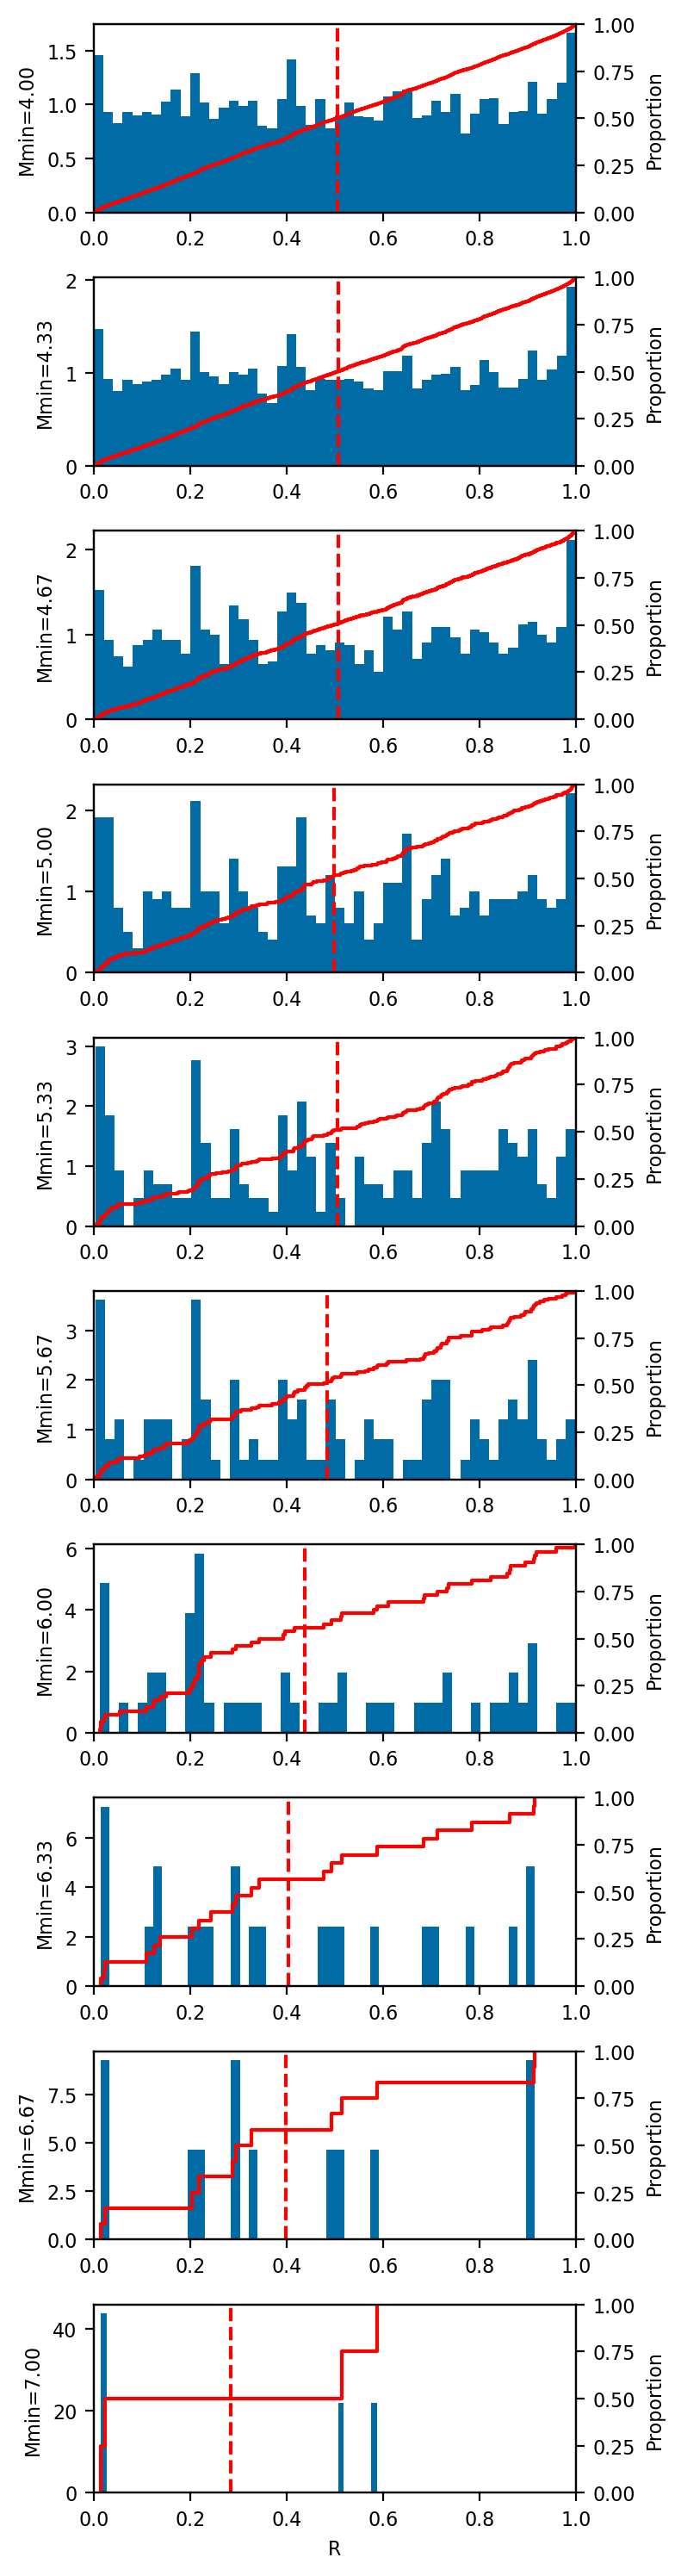

In [16]:
n_cuts = 10
fig, ax = plt.subplots(n_cuts,1,figsize=(4,n_cuts*1.5))
for mc,iax in zip(np.linspace(earthquakes.mag_completeness,7,n_cuts), ax):
    visualize_statistic(slowslip_events.catalog, earthquakes.catalog.loc[earthquakes.catalog.mag>mc], get_R_from_catalogs, ax=iax)
    iax.set(
        xlim = [0,1],
        ylabel = f"Mmin={mc:.2f}",
    )

ax[-1].set(
    xlabel="R"
)
plt.tight_layout()

## Note: 
- Afterslip in SSE dataset?
- Triggered SSE vs afterslip
- 

fig, ax = plt.subplots(2,1,sharex=True,dpi=200, figsize=(4,4))
n_range = [-1,100]

visualize_statistic(slowslip_events.catalog, earthquakes.catalog, get_n_from_catalogs, ax=ax[0], range=n_range)
ax[0].set_title('Earthquakes trigger slow slip')
visualize_statistic(earthquakes.catalog, slowslip_events.catalog, get_n_from_catalogs, ax=ax[1], range=n_range)
ax[1].set_title('Slow slip trigger earthquakes')

visualize_null_statistic(len(earthquakes.catalog), ax=ax[0], transform_to_n=True)
visualize_null_statistic(len(slowslip_events.catalog), ax=ax[1], transform_to_n=True)

ax[1].set_xlim(n_range)
ax[1].set_xlabel("n")
plt.tight_layout()

## Is seismicity during slow slip events higher than during background?

This is a funny question to ask given that there is almost always slow slip going on... somewhere. Below I plot the slow slip events not just in terms of the start time, but also, as shaded, over their whole duration. Darker areas entail multiple events going on at the same time.

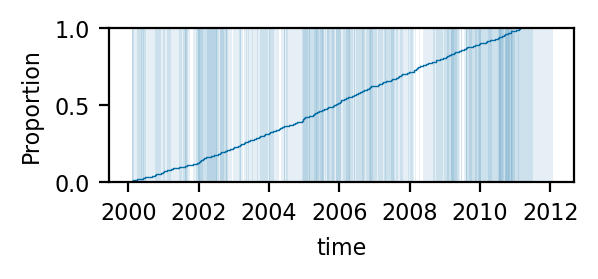

In [17]:
fig, ax = plt.subplots(figsize=(3,1))
[
    ax.axvspan(t,t+dt*np.timedelta64(1, 's'),alpha=0.1,edgecolor=None) 
    for t, dt in zip(slowslip_events.catalog['time'] , slowslip_events.catalog['duration']) 
    if not np.isnan(dt)
];

sns.ecdfplot(
    slowslip_events.catalog["time"],
    label="Slow Slip",
    **kwargs,
    ax=ax,
);

...so perhaps a more precise question to ask is wether there is more seismicity *during* and *nearby* slow slip. For this first pass, I simply compare the seismicity in a specified radius from slow slip events to so-called background periods. Here we go: 

/Users/kdascher/miniforge3/envs/torch_earthquake_stat/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/Users/kdascher/miniforge3/envs/torch_earthquake_stat/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


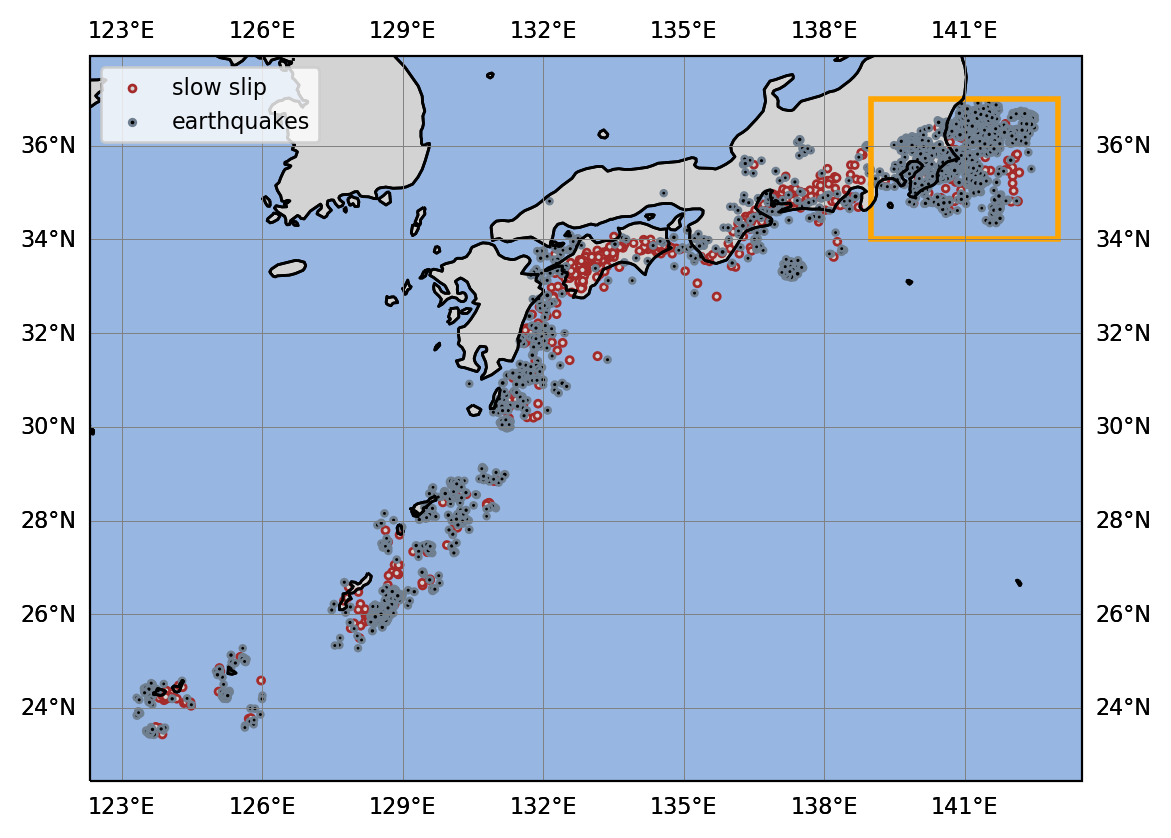

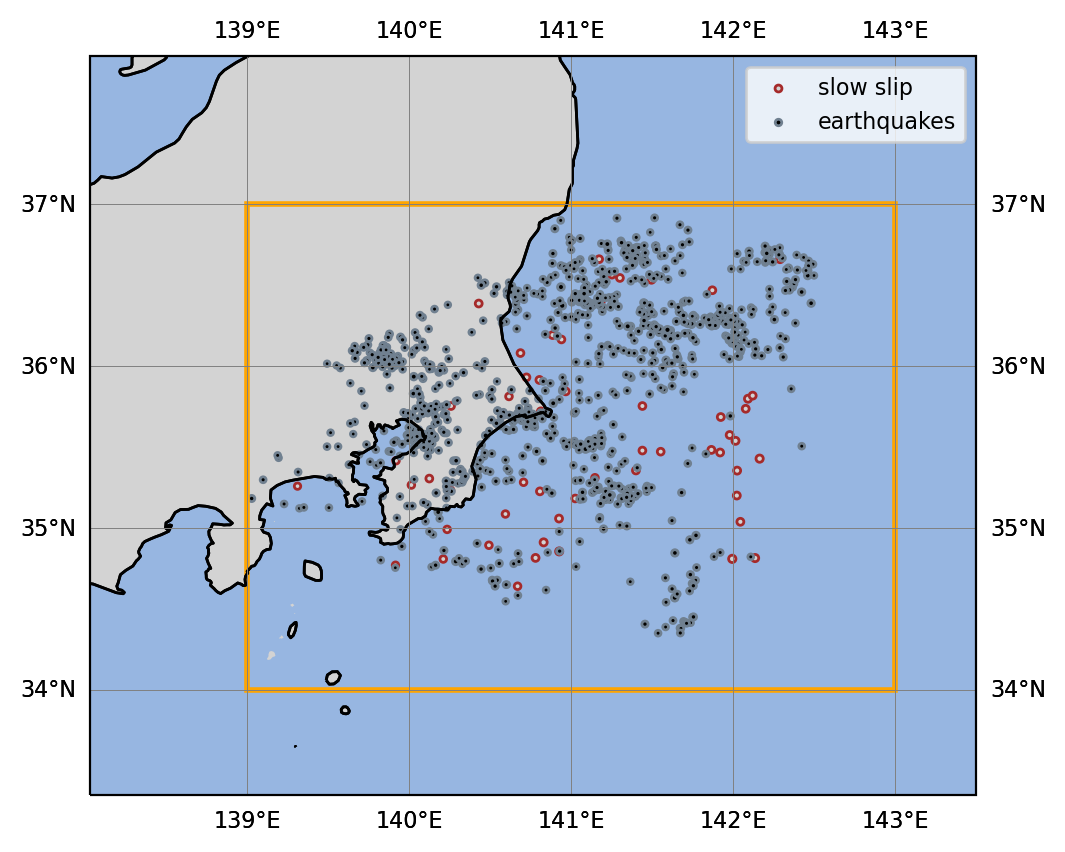

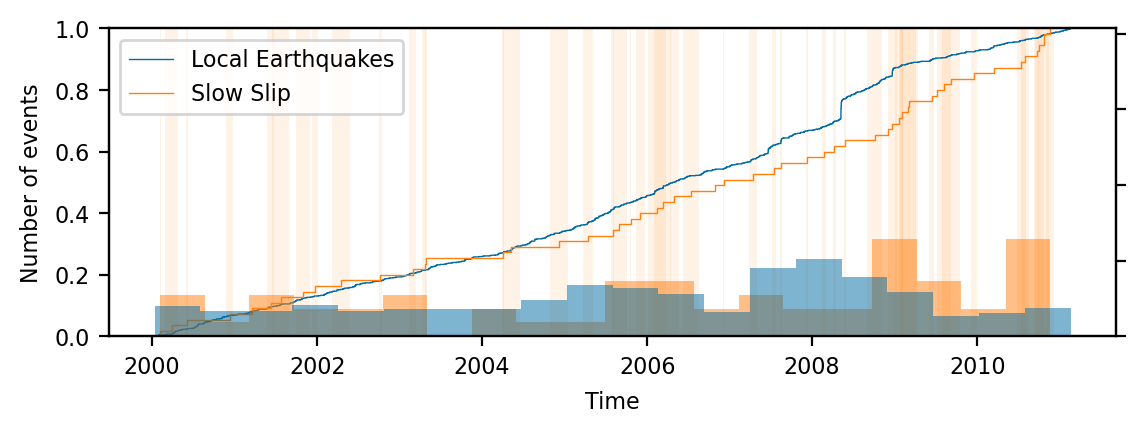

In [18]:
focus_areas = {
    'Southern Japan Trench': [
        [139,143],
        [34,37],
    ],
    'Nankai Trench': [
        [133,139],
        [32,36],
    ]
}

focus_area = focus_areas["Southern Japan Trench"]

ax = slowslip_events.plot_map()
local_earthquakes.plot_map(ax=ax,scatter_kwarg={"c":'k',"edgecolors":'slategrey'})
ax.legend(["slow slip","earthquakes"])

ax.add_patch(mpl.patches.Rectangle((focus_area[0][0], focus_area[1][0]), np.diff(focus_area[0]),np.diff(focus_area[1]), edgecolor='orange',
   facecolor='none', linewidth=2,transform=ccrs.Geodetic()))

slowslip_focus, earthquakes_focus = [
    cat.get_space_slice(focus_area[1],focus_area[0]) 
    for cat in [slowslip_events,local_earthquakes]
]

ax = slowslip_focus.plot_map()
earthquakes_focus.plot_map(ax=ax,scatter_kwarg={"c":'k',"edgecolors":'slategrey'})
ax.legend(["slow slip","earthquakes"])
ax.add_patch(mpl.patches.Rectangle((focus_area[0][0], focus_area[1][0]), np.diff(focus_area[0]),np.diff(focus_area[1]), edgecolor='orange',
   facecolor='none', linewidth=2,transform=ccrs.Geodetic()))

fig, ax = plt.subplots(figsize=(6.5,2))

kwargs = {'lw':0.5}

sns.ecdfplot(
    earthquakes_focus.catalog["time"], 
    label="Local Earthquakes",
    **kwargs,
    ax=ax,
)

sns.ecdfplot(
    slowslip_focus.catalog["time"],
    label="Slow Slip",
    **kwargs,
    ax=ax,
)

[
    ax.axvspan(t-dt/2*np.timedelta64(1, 's'),t+dt/2*np.timedelta64(1, 's'),alpha=0.1,color='C1',lw=0) 
    for t, dt in zip(slowslip_focus.catalog['time'], slowslip_focus.catalog['duration']) 
    if not np.isnan(dt)
];

axb = ax.twinx()
n_bin = 20
axb.hist(slowslip_focus.catalog.time, bins=n_bin,color='C1', alpha=0.5,density=True)
axb.hist(earthquakes_focus.catalog.time, bins=n_bin,color='C0', alpha=0.5,density=True)
ylim = axb.get_ylim()
axb.set_ylim(ylim[0], ylim[1]*3)
axb.set_yticklabels([])

ax.set_xlabel("Time")
ax.set_ylabel("Number of events")
ax.legend();

<AxesSubplot: xlabel='Time', ylabel='Distance along cross-section'>

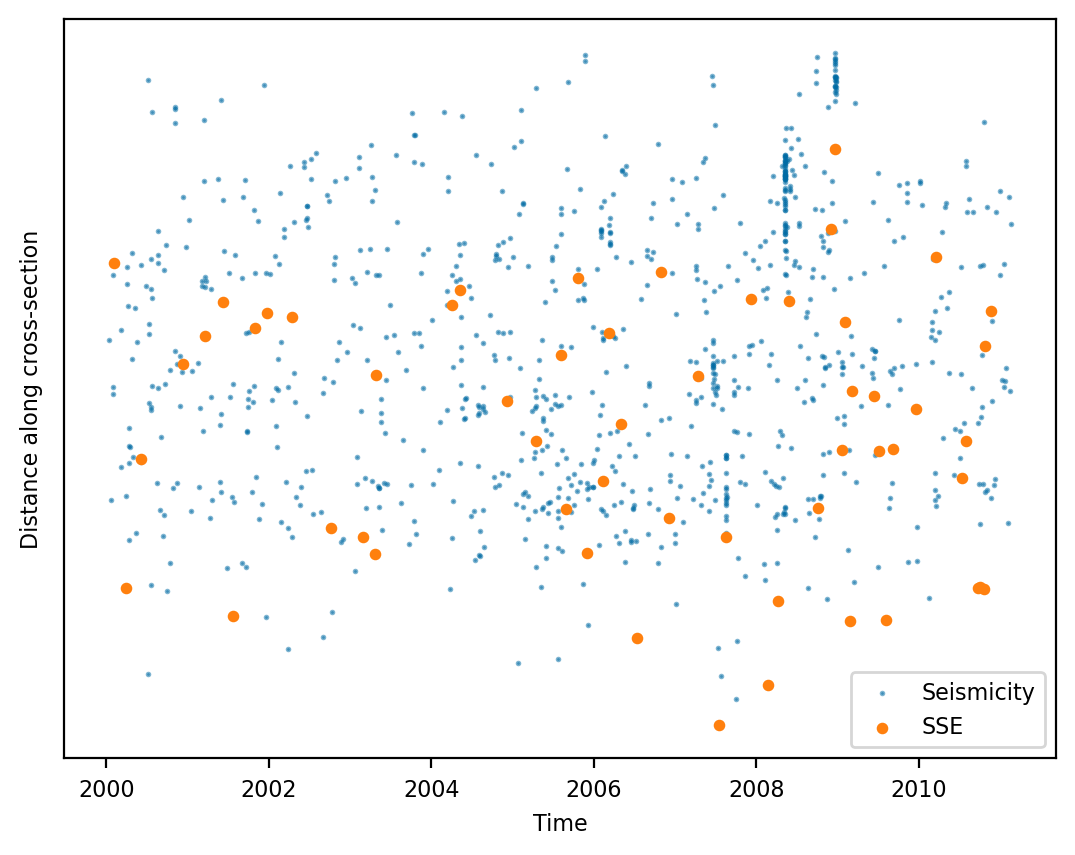

In [19]:
fig,ax = plt.subplots()
earthquakes_focus.plot_space_time_series(ax=ax,kwargs={"label":'Seismicity'})
slowslip_focus.plot_space_time_series(ax=ax,kwargs={"s":10,"alpha":1,"label":'SSE'})

Observation: the slow slip events and the earthquakes are not necessarily spatially correlated. This complicates things insofar as the occurence of slow slip will not correspond to the occurrence of earthuquakes. Particularly in ereas where there are no earthquakes to begin with.


/Users/kdascher/miniforge3/envs/torch_earthquake_stat/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


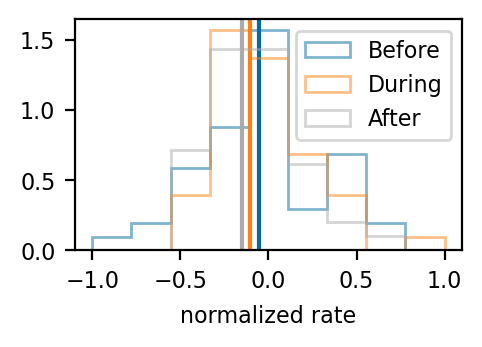

In [20]:
fig,ax = plt.subplots(figsize=(2.5,1.5))

slowslip_focus

keys = ['Before','During','After']
periods={}
for i in range(3):
    number_of_earthquakes = np.array([
        len(
            earthquakes_focus.slice_by(
                'time',
                t+np.timedelta64(1,'s')*dt*(i-1-0.5),t+np.timedelta64(1,'s')*dt*(i-0.5),
            )
        )
        if not (np.isnan(dt) or dt==0) else np.nan
        for t,dt in zip(slowslip_focus.catalog.time,slowslip_focus.catalog["duration"]) 
    ])
    rate_ratio =  number_of_earthquakes/len(earthquakes_focus) * earthquakes_focus.duration/(slowslip_focus.catalog.duration*np.timedelta64(1,'s')) 
    rate_ratio = (
        (number_of_earthquakes/len(earthquakes_focus)) * 
        earthquakes_focus.duration/(slowslip_focus.catalog.duration*np.timedelta64(1,'s'))
    )
    periods[keys[i]] = rate_ratio
    ax.hist(np.log10(rate_ratio),bins=np.linspace(-1,1,10), label=keys[i],alpha=0.5,density=True,histtype='step')
    ax.axvline(
        np.median(np.log10(rate_ratio[(~np.isnan(rate_ratio))])),
        c=f'C{i}'
    )
    ax.legend()
    ax.set_xlabel('normalized rate') 


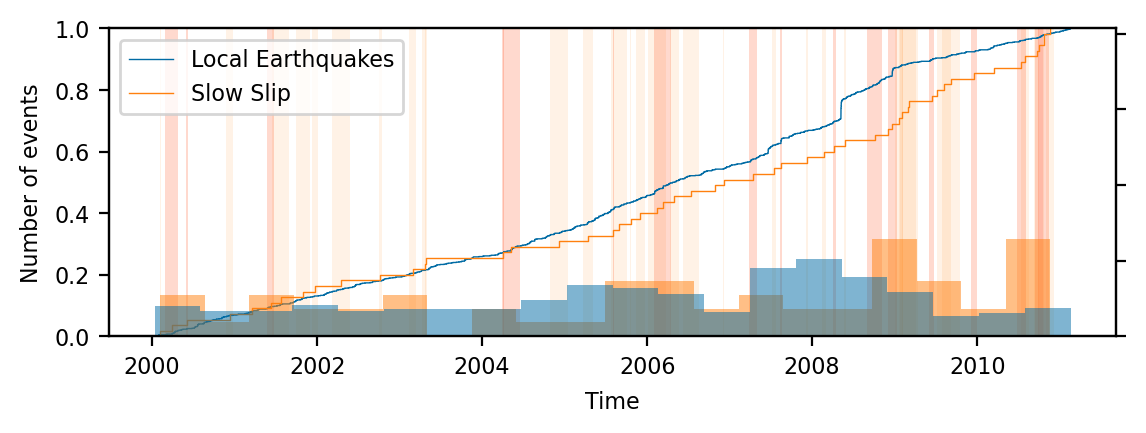

In [21]:
fig, ax = plt.subplots(figsize=(6.5,2))

kwargs = {'lw':0.5}

sns.ecdfplot(
    earthquakes_focus.catalog["time"], 
    label="Local Earthquakes",
    **kwargs,
    ax=ax,
)

sns.ecdfplot(
    slowslip_focus.catalog["time"],
    label="Slow Slip",
    **kwargs,
    ax=ax,
)

[
    ax.axvspan(t-0.5*dt*np.timedelta64(1, 's'),t+0.5*dt*np.timedelta64(1, 's'),alpha=0.1,color='C1',lw=0) 
    for t, dt in zip(slowslip_focus.catalog['time'], slowslip_focus.catalog['duration']) 
    if not np.isnan(dt)
];

axb = ax.twinx()
n_bin = 20
axb.hist(slowslip_focus.catalog.time, bins=n_bin,color='C1', alpha=0.5,density=True)
axb.hist(earthquakes_focus.catalog.time, bins=n_bin,color='C0', alpha=0.5,density=True)
ylim = axb.get_ylim()
axb.set_ylim(ylim[0], ylim[1]*3)
axb.set_yticklabels([])

ax.set_xlabel("Time")
ax.set_ylabel("Number of events")
ax.legend();

[
    ax.axvspan(t-0.5*dt*np.timedelta64(1, 's'),t+0.5*dt*np.timedelta64(1, 's'),alpha=0.1,color='r',lw=0) 
    for t, dt, dr in zip(slowslip_focus.catalog['time'], slowslip_focus.catalog['duration'],periods['During']/periods['Before']) 
    if not np.isnan(dt) and dr > 1.5
];

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


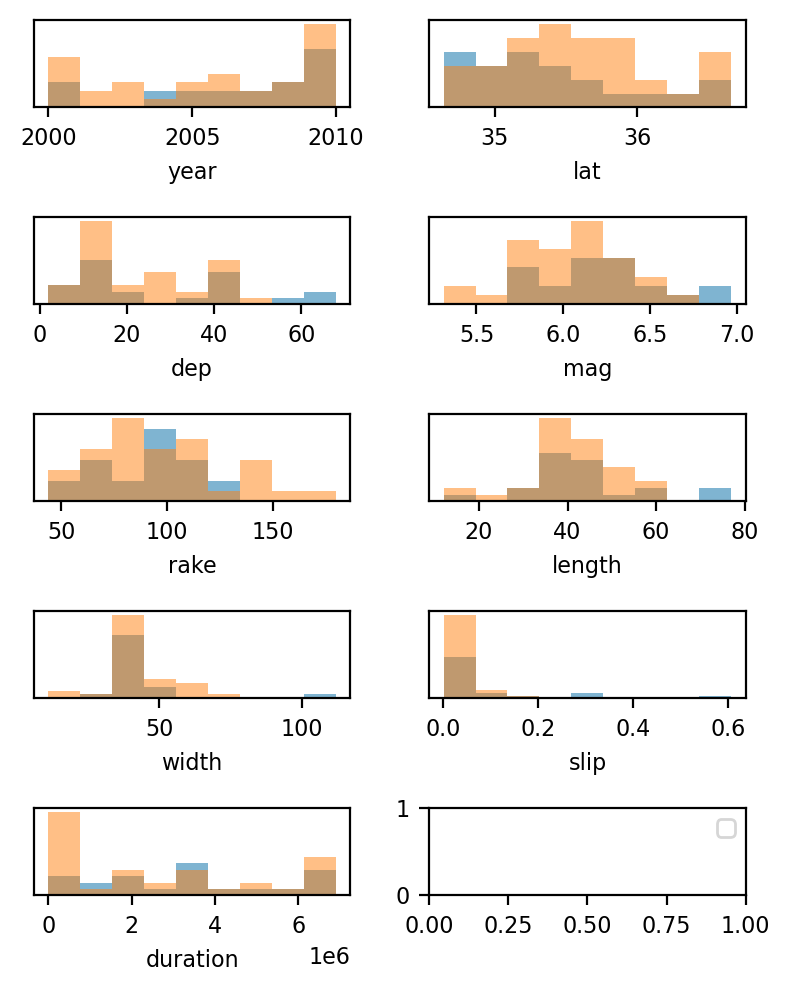

In [22]:
def visual_slice_comparison(df,slice,keys=None,labels=None):
    if keys is None:
        keys = df.keys()
    if labels is None:
        labels=["True","False"]
    else:
        assert len(labels) == 2

    fig, ax = plt.subplots(int(np.ceil(len(keys)/2)),2, figsize=[4,1*np.ceil(len(keys)/2)])

    ax = ax.flatten()

    for k, iax in zip(keys,ax):
        bins = np.linspace(df[k].min(),df[k].max(),10)
        iax.hist(df.loc[slice][k], bins=bins, label=labels[0], alpha=0.5)
        iax.hist(df.loc[~slice][k], bins=bins, label=labels[1], alpha=0.5)
        iax.set(
            ylabel=None,
            yticks=[],
            xlabel=k,
        )
    ax[-1].legend()

    plt.tight_layout()

visual_slice_comparison(
    slowslip_focus.catalog,
    (periods['During']/periods['Before'] > 1).values,
    [
        "year",
        "lat",
        "dep",
        "mag",
        "rake",
        "length",
        "width",
        "slip",
        "duration",
    ],
    labels=['Productive','Unproductive']
);

[None,
 Text(0, 0.5, 'Normalized rate of seismicity, $\\dfrac{N_{SS}}{N_{tot}} / \\dfrac{T_{SS}}{T_{tot}}$'),
 Text(0.5, 0, 'Magnitude')]

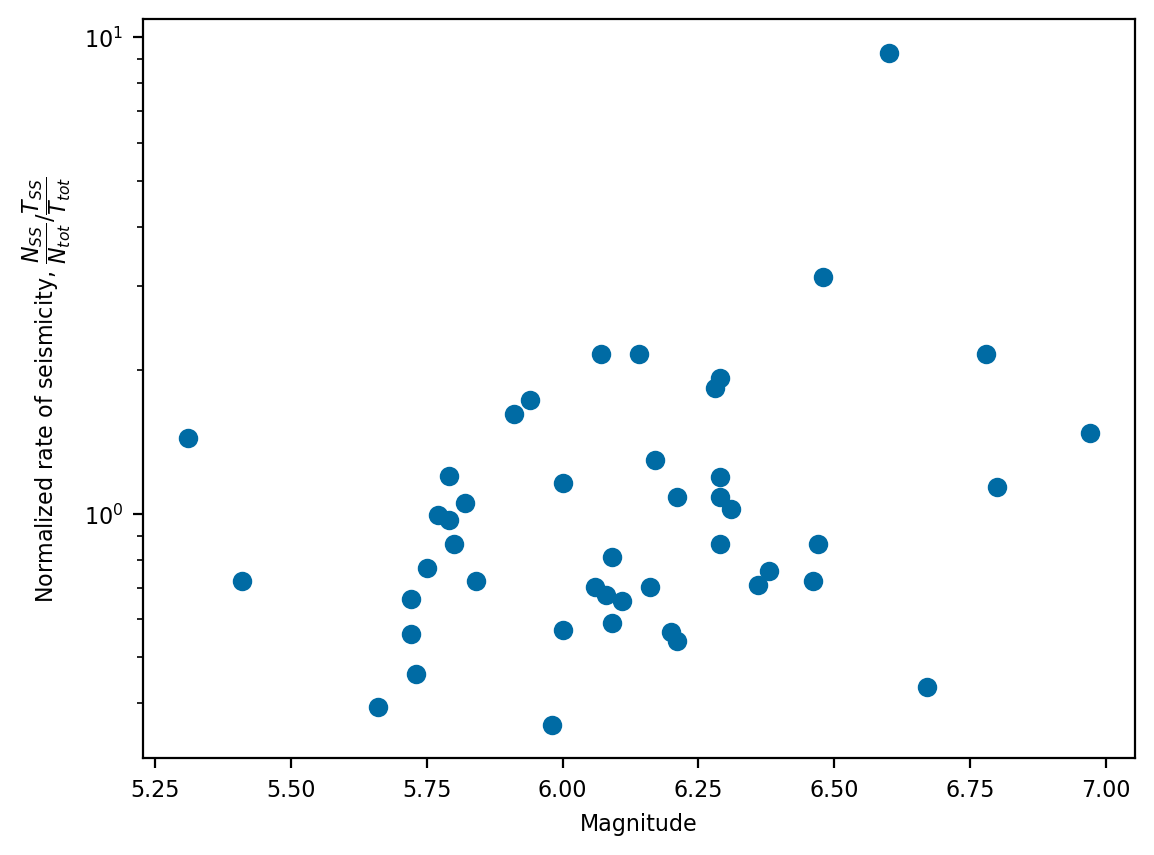

In [23]:
fig, ax = plt.subplots()
ax.scatter(slowslip_focus.catalog['mag'], periods["During"])
ax.set(
    yscale='log',
    ylabel='Normalized rate of seismicity, $\dfrac{N_{SS}}{N_{tot}} / \dfrac{T_{SS}}{T_{tot}}$',
    xlabel='Magnitude',
)


Explanation for the plot above: I looked at whether events dispropostionally occur during slow slip. What I came up with is to assume that if there is no tendency for elevated seismicity, then: 

$$ \dfrac{N_{SS}}{N_{tot}} = \dfrac{T_{SS}}{T_{tot}} $$

The plot above is looking at the histogram of the log-comparison of these two quantities. If they are zero, then there is no signal in the data. If there is a tendency for elevated seismicity then I would expect the log-ratio to be higher than zero. 

From the looks of it there does not seem to be any relationship.

For reference, I also include the following from Nishikawa et al., 2023 :

![FIGURE](Nishikawa_Fig5.webp)

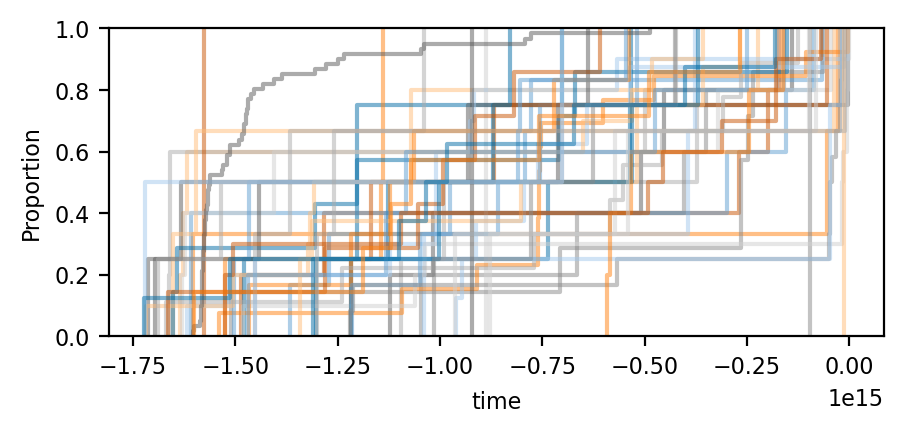

In [24]:
fig, ax = plt.subplots(figsize=(5,2))
dt = np.timedelta64(20,'D')
[
    sns.ecdfplot(earthquakes_focus.slice_by('time',t-dt, t).catalog.time-t, alpha=0.5, ax=ax) 
    for t in slowslip_focus.catalog.time.values
    if len(earthquakes_focus.slice_by('time',t-dt, t)) > 0
];

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_34972/3614598702.py:8: RuntimeWarning: invalid value encountered in divide
  precursory_phase = np.nansum([1-r/r[0] for r in precursory_phase],axis=0)/len(slowslip_focus)


Text(0, 0.5, 'Cummulative proportion\nof earthquakes')

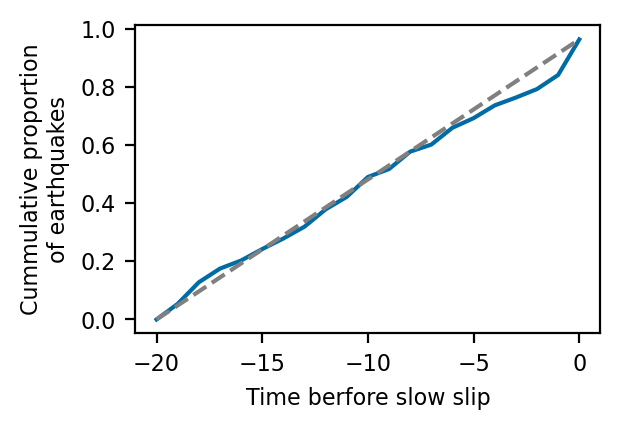

In [25]:
time_range = np.linspace(-20,0,200)*np.timedelta64(1,'D')
precursory_phase = np.array([
    [len(earthquakes_focus.slice_by("time",t+dt,t)) 
    for dt in time_range] 
    for t in slowslip_focus.catalog.time.values
])

precursory_phase = np.nansum([1-r/r[0] for r in precursory_phase],axis=0)/len(slowslip_focus)

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(time_range, precursory_phase);
ax.plot(time_range[[0,-1]],precursory_phase[[0,-1]],c='grey',ls='--')
ax.set_xlabel('Time berfore slow slip')
ax.set_ylabel('Cummulative proportion\nof earthquakes')

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_34972/3896339860.py:8: RuntimeWarning: invalid value encountered in divide
  precursory_phase = np.nansum([1-r/r[-1] for r in precursory_phase],axis=0)/len(slowslip_focus)


Text(0, 0.5, 'Cummulative propostion\nof earthquakes')

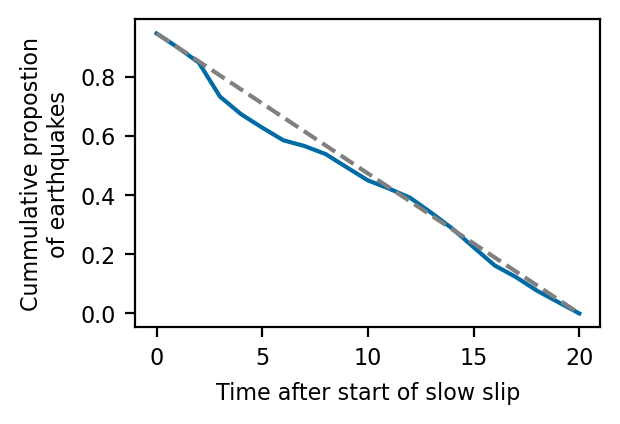

In [26]:
time_range = np.linspace(0,20,200)*np.timedelta64(1,'D')
precursory_phase = np.array([
    [len(earthquakes_focus.slice_by("time",t,t+dt)) 
    for dt in time_range] 
    for t in slowslip_focus.catalog.time.values
])

precursory_phase = np.nansum([1-r/r[-1] for r in precursory_phase],axis=0)/len(slowslip_focus)

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(time_range, precursory_phase);
ax.plot(time_range[[0,-1]],precursory_phase[[0,-1]],c='grey',ls='--')
ax.set_xlabel('Time after start of slow slip')
ax.set_ylabel('Cummulative propostion\nof earthquakes')

Some back of the enveloppe thoughts:

There is a lot conspiring against slow slip contributing significantly to the seismicity rate. For starters, here we are looking at relatively large earthquakes. Bhadt's law reminds us that the change we expect roughly one aftershock a magnitude increment less for the typical earthuqake. Now lets consider slow slip, one notable characteristic of slow slip is that the stress drop is significantly smaller. It is reasonable to expect that, all else held equal, the rate of aftershocks will be proportional to the stress drop.

This is what I would predict it should be:

$$ N \sim \rho V \sim \rho L^3 $$

However, empirically, if I recal correctly aftershock prodoctivity scales as the area (Yamanaka & Shimazaki, 1990) so:

$$ N \sim \rho A \sim \rho L^2 $$

I've pondered whether a similar saling relationship could arise from a circular taurus, where the volume is controlled by the circumference, which goes as $2\pi L$ and the radius which goes as the length scale of the stress perturbation, which then scales as the source dimension (?) and the stress drop (?). I actually do not thinks this works out upon second thought...

If productivity is propositional to stress drop (thinking about some of Dieterich's thinking here), then kPa's vs MPa's would result in 1000 times fewer aftershocks, or, in terms of Badth law, the largest aftershock would be a 4 magnitude units smaller (?). Therefore considering the slow slip events here, all smaller than M7. Then, the largest afterschock would be a M4, still below the cutoff of this analysis.

Some open questions here...

It would be compelling to be a bit more explicit about the aftershock productivity predictions. I anticipate that we could be a bit more explicit about the predictions for the pre-factor. Afterall, the dimensions need to work, and we do have a sense of what should matter. To some degree the *absence* of slow slip might be an indication of this relationsip. 
